In [12]:
# === Config ===
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 프로젝트 루트 (너의 경로로 바꿔)
PROJECT_ROOT = Path("/home/piai/yejin/nscaleup")

# 원본 이미지 폴더
IMG_DIR = PROJECT_ROOT / "data" / "images"

# 예측 마스크 폴더(각 파일: 단일채널 PNG, 픽셀값=클래스ID)
# 예: eval시에 저장한 폴더나 runs/.../pred_masks 와 같이 지정
PRED_MASK_DIR = PROJECT_ROOT / "masks_3"

# (선택) 평가 대상 리스트 파일. 없으면 None (basename 매칭으로 자동 탐색)
SPLIT_FILE = PROJECT_ROOT / "splits" / "val.txt"   # 없으면 None

# 결과 저장 폴더
OUTPUT_DIR = PROJECT_ROOT / "viz_eval_overlays"

# 클래스 정보 (배경 포함 총 개수)
NUM_CLASSES = 4                     # 0: background + 3 classes
CLASS_NAMES = ["0", "1", "2", "3"]  # 네 데이터에 맞게 수정

# 클래스별 RGBA 색 (0~255). 배경은 완전 투명 (alpha=0) 권장
CLASS_COLORS = [
    (0, 0, 0, 0),        # background (transparent)
    (255, 0, 0, 100),    # lawn: red
    (0, 255, 0, 100),    # tree: green
    (0, 0, 255, 100),    # building: blue
]

# 인라인으로 미리보기 할 샘플 수 (0이면 미리보기 생략)
NUM_DISPLAY = 6

# === Utils ===
def _read_split_file(p: Path):
    names = []
    with open(p, "r") as f:
        for ln in f:
            ln = ln.strip()
            if not ln:
                continue
            names.append(Path(ln).stem)
    return names

def _collect_pairs(img_dir: Path, mask_dir: Path, split_file: Path|None):
    img_exts = [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]
    pairs = []
    if split_file and split_file.exists():
        names = _read_split_file(split_file)
        for name in names:
            ip = next((img_dir / f"{name}{e}" for e in img_exts if (img_dir / f"{name}{e}").exists()), None)
            mp = mask_dir / f"{name}.png"
            if ip and mp.exists():
                pairs.append((ip, mp))
    else:
        # basename 매칭
        for ip in sorted(img_dir.rglob("*")):
            if ip.suffix.lower() not in img_exts:
                continue
            mp = mask_dir / f"{ip.stem}.png"
            if mp.exists():
                pairs.append((ip, mp))
    return pairs

def _load_rgb(p: Path):
    return np.array(Image.open(p).convert("RGB"))

def _load_mask(p: Path):
    im = Image.open(p)
    if im.mode != "L":
        im = im.convert("L")
    return np.array(im, dtype=np.int32)

def _colored_rgba(mask: np.ndarray, num_classes: int, class_colors: list[tuple[int,int,int,int]]):
    h, w = mask.shape
    rgba = np.zeros((h, w, 4), dtype=np.uint8)
    for c in range(num_classes):
        col = class_colors[c]
        idx = (mask == c)
        if idx.any():
            rgba[idx] = col
    return Image.fromarray(rgba, mode="RGBA")

def _overlay(image_rgb: np.ndarray, rgba_mask_img: Image.Image):
    base = Image.fromarray(image_rgb).convert("RGBA")
    # 크기 불일치 시, 마스크를 이미지 크기에 맞춤 (최근접 보간)
    if rgba_mask_img.size != base.size:
        rgba_mask_img = rgba_mask_img.resize(base.size, resample=Image.NEAREST)
    return Image.alpha_composite(base, rgba_mask_img).convert("RGB")

def _ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def _legend(class_names, class_colors):
    fig, ax = plt.subplots(figsize=(4, 1 + 0.28*len(class_names)))
    ax.axis("off")
    for i, (name, col) in enumerate(zip(class_names, class_colors)):
        c = tuple(v/255 for v in col)
        ax.barh(i, 1, color=c, edgecolor="k")
        ax.text(1.05, i, f"{i}: {name}", va="center", fontsize=11)
    ax.set_ylim(-1, len(class_names))
    ax.set_xlim(0, 1.6)
    fig.tight_layout()
    return fig


Found 122 (image, mask) pairs.
Saved colored masks -> /home/piai/yejin/nscaleup/viz_eval_overlays/colored_masks
Saved overlays     -> /home/piai/yejin/nscaleup/viz_eval_overlays/overlays


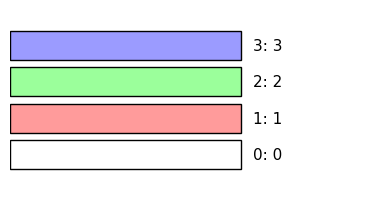

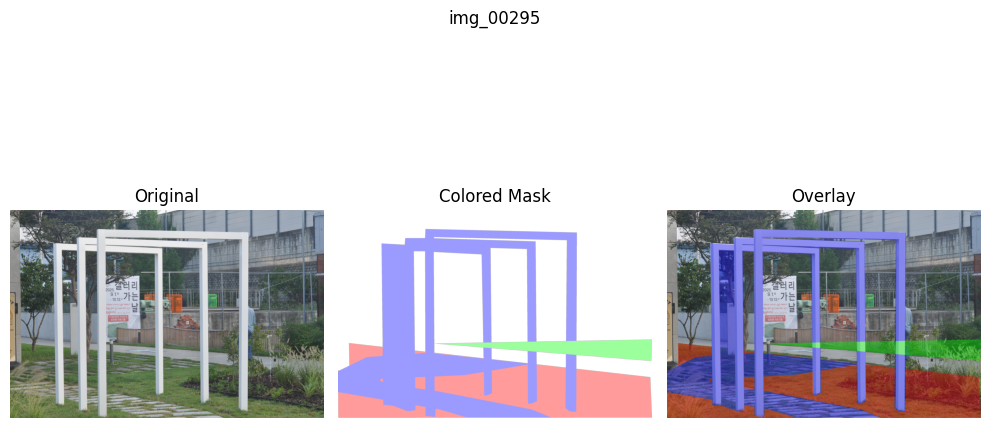

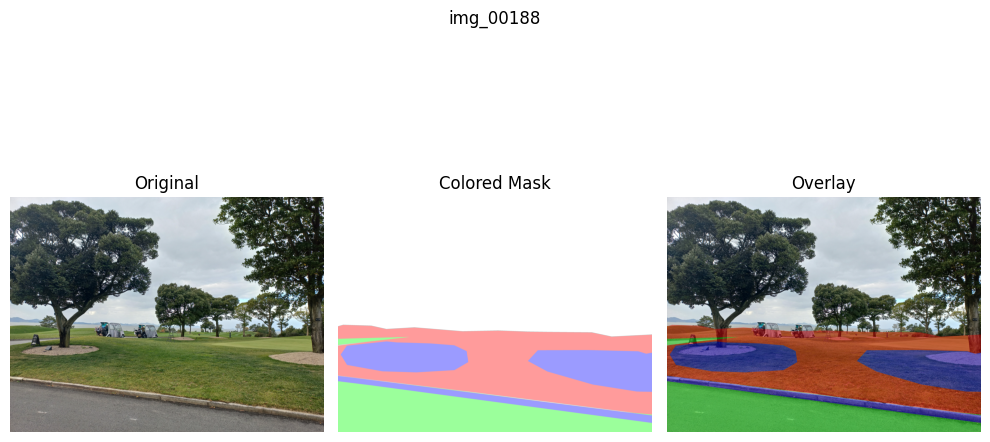

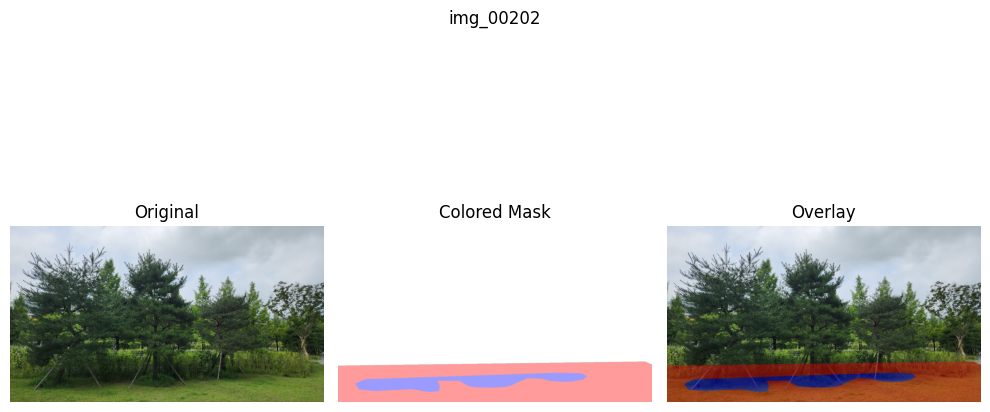

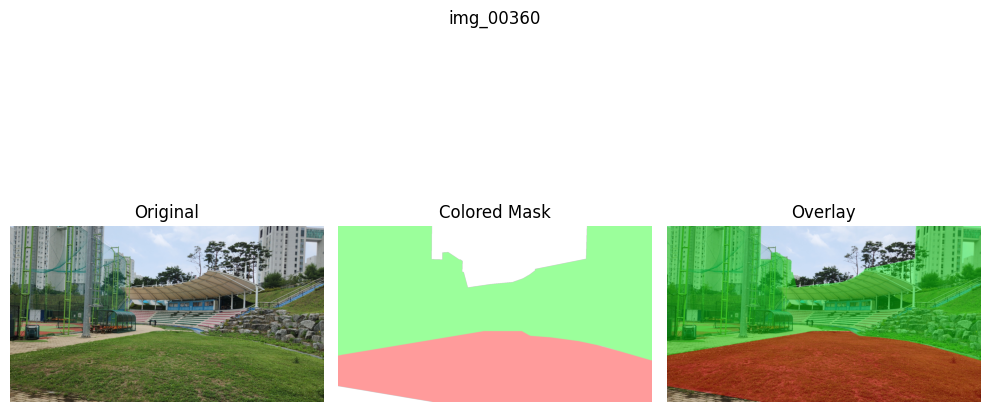

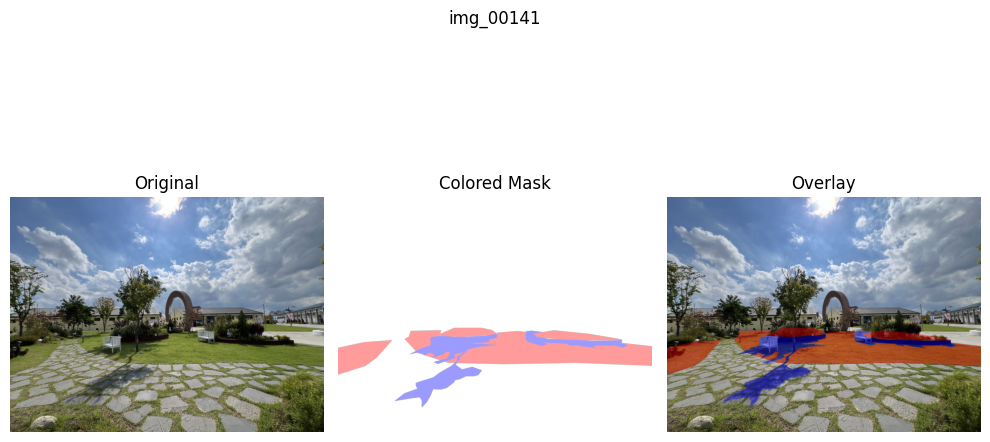

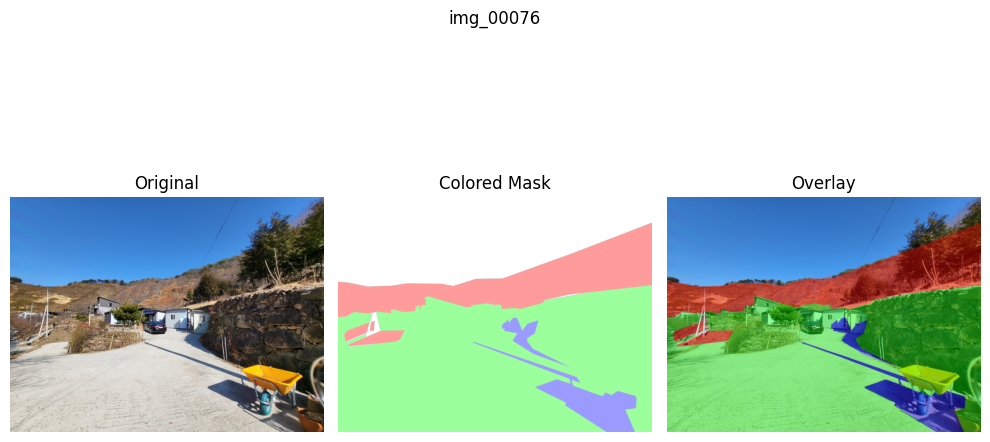

In [13]:
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 페어 수집
pairs = _collect_pairs(IMG_DIR, PRED_MASK_DIR, SPLIT_FILE)
print(f"Found {len(pairs)} (image, mask) pairs.")

# 출력 폴더 준비
colored_dir = OUTPUT_DIR / "colored_masks"
overlay_dir = OUTPUT_DIR / "overlays"
_ensure_dir(colored_dir); _ensure_dir(overlay_dir)

# 생성/저장
saved = []
for ip, mp in pairs:
    img = _load_rgb(ip)
    msk = _load_mask(mp)
    msk = np.clip(msk, 0, NUM_CLASSES-1)

    rgba = _colored_rgba(msk, NUM_CLASSES, CLASS_COLORS)
    ov  = _overlay(img, rgba)

    cm_path = colored_dir / f"{ip.stem}_colored.png"
    ov_path = overlay_dir / f"{ip.stem}_overlay.jpg"
    rgba.save(cm_path)
    ov.save(ov_path, quality = 95)
    saved.append((ip, cm_path, ov_path))

print("Saved colored masks ->", colored_dir)
print("Saved overlays     ->", overlay_dir)

# 미리보기
if NUM_DISPLAY and len(saved) > 0:
    _legend(CLASS_NAMES[:NUM_CLASSES], CLASS_COLORS[:NUM_CLASSES]); plt.show()
    for (ip, cm, ov) in saved[:NUM_DISPLAY]:
        fig = plt.figure(figsize=(10, 6))
        fig.suptitle(ip.stem, y=0.98, fontsize=12)

        ax1 = fig.add_subplot(1,3,1); ax1.set_title("Original"); ax1.axis("off")
        ax1.imshow(Image.open(ip).convert("RGB"))

        ax2 = fig.add_subplot(1,3,2); ax2.set_title("Colored Mask"); ax2.axis("off")
        ax2.imshow(Image.open(cm).convert("RGBA")) 

        ax3 = fig.add_subplot(1,3,3); ax3.set_title("Overlay"); ax3.axis("off")
        ax3.imshow(Image.open(ov).convert("RGB"))
        plt.tight_layout(); plt.show()


GT vs Pred

In [ ]:
from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import csv

# ==== 경로 설정 (네 환경에 맞게 수정) ====
PROJECT_ROOT = Path("/home/piai/yejin/nscaleup")
IMG_DIR      = PROJECT_ROOT / "data" / "images"       # 원본 이미지
GT_MASK_DIR  = PROJECT_ROOT / "data" / "labels"       # GT 마스크(.png, 단일채널, 0=bg)
PRED_MASK_DIR= PROJECT_ROOT / "runs/3cls_20250923_040545/pred_masks"  # 예측 마스크
SPLIT_FILE   = PROJECT_ROOT / "splits" / "val.txt"    # 없으면 None

# 출력 폴더
OUT_ROOT     = PROJECT_ROOT / "viz_compare"           # 전체 출력 루트
PANELS_DIR   = OUT_ROOT / "panels"                    # 패널(Original/GT/Pred/Overlay/Error)
ERRORMAP_DIR = OUT_ROOT / "errormaps"                 # 에러맵 단독
CSV_METRICS  = OUT_ROOT / "metrics.csv"               # per-image 지표 저장

# ==== 클래스 정보 ====
NUM_CLASSES  = 4  # 0=배경 + 3클래스
CLASS_NAMES  = ["background", "lawn", "tree", "building"]  # 실제 이름으로 수정

# 클래스별 RGBA (0~255) — 논문용 색상 맞춰 조정
CLASS_COLORS = [
    (0, 0, 0,   0),   # background (transparent)
    (255, 0, 0, 160), # lawn
    (0, 255, 0, 160), # tree
    (0, 0, 255, 160), # building
]

# 에러맵 색상 (오버레이용 RGBA)
ERR_COLORS = {
    "TP": (0, 0, 0, 0),            # 정분류: 표시 안 함(투명)
    "FP": (255, 0, 255, 160),      # 과탐(배경→클래스 또는 잘못된 클래스): magenta
    "FN": (0, 255, 255, 160),      # 미탐(클래스→배경): cyan
    "MIS": (255, 255, 0, 160),     # 오분류(클래스A→클래스B): yellow
}

# 미리보기 개수 (0이면 미리보기 생략)
NUM_DISPLAY = 8

# ========== 유틸 ==========
def _ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def _read_split_file(p: Path):
    names = []
    with open(p, "r") as f:
        for ln in f:
            ln = ln.strip()
            if ln:
                names.append(Path(ln).stem)
    return names

def _load_img(p: Path):
    return np.array(Image.open(p).convert("RGB"))

def _load_mask(p: Path):
    im = Image.open(p)
    if im.mode != "L":
        im = im.convert("L")
    return np.array(im, dtype=np.int32)

def _colored_rgba(mask: np.ndarray, class_colors: list[tuple[int,int,int,int]]):
    h, w = mask.shape
    rgba = np.zeros((h, w, 4), dtype=np.uint8)
    for c, col in enumerate(class_colors):
        idx = (mask == c)
        if idx.any():
            rgba[idx] = col
    return Image.fromarray(rgba, mode="RGBA")

def _overlay_rgb(base_rgb: np.ndarray, overlay_rgba: Image.Image):
    base = Image.fromarray(base_rgb).convert("RGBA")
    out = Image.alpha_composite(base, overlay_rgba)
    return out.convert("RGB")

def _legend(classes, colors):
    fig, ax = plt.subplots(figsize=(4, 1 + 0.28*len(classes)))
    ax.axis("off")
    for i, (n, col) in enumerate(zip(classes, colors)):
        c = tuple(v/255 for v in col)
        ax.barh(i, 1, color=c, edgecolor="k")
        ax.text(1.05, i, f"{i}: {n}", va="center")
    ax.set_ylim(-1, len(classes)); ax.set_xlim(0, 1.6); fig.tight_layout()
    return fig

def _error_overlay(gt: np.ndarray, pred: np.ndarray):
    """에러 타입별 RGBA 오버레이 생성 (TP 투명, FP/FN/MIS 반투명 색). 배경(0)은 오차 판정 시 컨텍스트로 사용."""
    h, w = gt.shape
    rgba = np.zeros((h, w, 4), dtype=np.uint8)
    same = (gt == pred)

    # FP: pred!=0 & gt==0
    fp = (pred != 0) & (gt == 0)
    rgba[fp] = ERR_COLORS["FP"]

    # FN: gt!=0 & pred==0
    fn = (gt != 0) & (pred == 0)
    rgba[fn] = ERR_COLORS["FN"]

    # MIS: 둘 다 !=0 이지만 클래스가 다름
    mis = (gt != 0) & (pred != 0) & (~same)
    rgba[mis] = ERR_COLORS["MIS"]

    return Image.fromarray(rgba, mode="RGBA")

def _pair_paths(img_dir: Path, gt_dir: Path, pred_dir: Path, split_file: Path|None):
    exts = [".jpg",".jpeg",".png",".bmp",".tif",".tiff"]
    pairs = []
    names = None
    if split_file and split_file.exists():
        names = _read_split_file(split_file)
    if names is None:
        # 이미지 기준으로 basename 매칭
        names = []
        for ip in img_dir.rglob("*"):
            if ip.suffix.lower() in exts:
                names.append(ip.stem)

    for name in names:
        ip = next((img_dir / f"{name}{e}" for e in exts if (img_dir / f"{name}{e}").exists()), None)
        gp = gt_dir / f"{name}.png"
        pp = pred_dir / f"{name}.png"
        if ip and gp.exists() and pp.exists():
            pairs.append((name, ip, gp, pp))
    return pairs

def _confusion_2d(gt: np.ndarray, pred: np.ndarray, num_classes: int):
    # 벡터화된 confusion matrix
    mask = (gt >= 0) & (gt < num_classes)
    labels = num_classes * gt[mask].astype(int) + pred[mask].astype(int)
    count = np.bincount(labels, minlength=num_classes**2)
    return count.reshape(num_classes, num_classes)

def _metrics_from_cm(cm: np.ndarray):
    # per-class IoU/F1, 전체 mIoU/mF1
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    denom_iou = (tp + fp + fn)
    iou = np.divide(tp, denom_iou, out=np.zeros_like(tp, dtype=float), where=denom_iou>0)
    f1  = np.divide(2*tp, 2*tp + fp + fn, out=np.zeros_like(tp, dtype=float), where=(2*tp + fp + fn)>0)
    miou = iou.mean()
    mf1  = f1.mean()
    return iou, f1, miou, mf1, tp.sum()/cm.sum() if cm.sum()>0 else 0.0


In [ ]:
# 출력 폴더 준비
_ensure_dir(OUT_ROOT); _ensure_dir(PANELS_DIR); _ensure_dir(ERRORMAP_DIR)

# 페어링
pairs = _pair_paths(IMG_DIR, GT_MASK_DIR, PRED_MASK_DIR, SPLIT_FILE)
print(f"Found {len(pairs)} pairs.")

# 전체 혼동행렬 누적
cm_total = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)
rows_for_csv = []

# 패널 생성 루프
for name, ip, gp, pp in pairs:
    img  = _load_img(ip)
    gt   = _load_mask(gp)
    pred = _load_mask(pp)
    # 안전: 클래스 범위 클램프
    gt   = np.clip(gt,   0, NUM_CLASSES-1)
    pred = np.clip(pred, 0, NUM_CLASSES-1)

    # per-image confusion & metrics
    cm = _confusion_2d(gt, pred, NUM_CLASSES)
    cm_total += cm
    iou, f1, miou, mf1, acc = _metrics_from_cm(cm)

    # 컬러 마스크 & 오버레이
    gt_rgba   = _colored_rgba(gt,   CLASS_COLORS)
    pred_rgba = _colored_rgba(pred, CLASS_COLORS)
    ov_gt     = _overlay_rgb(img, gt_rgba)
    ov_pred   = _overlay_rgb(img, pred_rgba)

    # 에러맵(오버레이)
    err_rgba  = _error_overlay(gt, pred)
    err_ov    = _overlay_rgb(img, err_rgba)

    # 패널 저장 (Original | GT | Pred | Overlay(Pred) | ErrorMap)
    fig = plt.figure(figsize=(16, 6))
    fig.suptitle(name, y=0.98, fontsize=12)

    ax = fig.add_subplot(1,5,1); ax.set_title("Original"); ax.axis("off"); ax.imshow(img)
    ax = fig.add_subplot(1,5,2); ax.set_title("GT (colored)"); ax.axis("off"); ax.imshow(gt_rgba)
    ax = fig.add_subplot(1,5,3); ax.set_title("Pred (colored)"); ax.axis("off"); ax.imshow(pred_rgba)
    ax = fig.add_subplot(1,5,4); ax.set_title("Overlay (Pred)"); ax.axis("off"); ax.imshow(ov_pred)
    ax = fig.add_subplot(1,5,5); ax.set_title("Error Map"); ax.axis("off"); ax.imshow(err_ov)
    fig.tight_layout()
    fig.savefig(PANELS_DIR / f"{name}_panel.jpg", dpi=200)
    plt.close(fig)

    # 에러맵 단독 저장
    Image.fromarray(err_ov).save(ERRORMAP_DIR / f"{name}_errormap.jpg", quality=95)

    # CSV용 행
    row = {
        "name": name,
        "pixel_acc": float(acc),
        "miou": float(miou),
        "mf1": float(mf1)
    }
    for c, (ciou, cf1) in enumerate(zip(iou, f1)):
        row[f"IoU_c{c}"] = float(ciou)
        row[f"F1_c{c}"]  = float(cf1)
    rows_for_csv.append(row)

# 전체 지표
iou_all, f1_all, miou_all, mf1_all, acc_all = _metrics_from_cm(cm_total)
print("\n=== Overall (all images) ===")
print(f"PixelAcc: {acc_all:.4f} | mIoU: {miou_all:.4f} | mF1: {mf1_all:.4f}")
for c in range(NUM_CLASSES):
    print(f"  Class {c} ({CLASS_NAMES[c]}): IoU={iou_all[c]:.4f}, F1={f1_all[c]:.4f}")

# CSV 저장
_ensure_dir(OUT_ROOT)
with open(CSV_METRICS, "w", newline="") as f:
    fieldnames = list(rows_for_csv[0].keys()) if rows_for_csv else []
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(rows_for_csv)

print(f"\nSaved panels  -> {PANELS_DIR}")
print(f"Saved errors  -> {ERRORMAP_DIR}")
print(f"Saved metrics -> {CSV_METRICS}")

# 미리보기(범례 + N개)
_legend(CLASS_NAMES[:NUM_CLASSES], CLASS_COLORS[:NUM_CLASSES]); plt.show()
for i, (name, ip, gp, pp) in enumerate(pairs[:NUM_DISPLAY]):
    fig = plt.figure(figsize=(16, 6))
    fig.suptitle(name, y=0.98, fontsize=12)

    img  = _load_img(ip)
    gt   = _load_mask(gp)
    pred = _load_mask(pp)
    gt   = np.clip(gt,   0, NUM_CLASSES-1)
    pred = np.clip(pred, 0, NUM_CLASSES-1)

    gt_rgba   = _colored_rgba(gt, CLASS_COLORS)
    pred_rgba = _colored_rgba(pred, CLASS_COLORS)
    ov_pred   = _overlay_rgb(img, pred_rgba)
    err_ov    = _overlay_rgb(img, _error_overlay(gt, pred))

    ax = fig.add_subplot(1,5,1); ax.set_title("Original"); ax.axis("off"); ax.imshow(img)
    ax = fig.add_subplot(1,5,2); ax.set_title("GT (colored)"); ax.axis("off"); ax.imshow(gt_rgba)
    ax = fig.add_subplot(1,5,3); ax.set_title("Pred (colored)"); ax.axis("off"); ax.imshow(pred_rgba)
    ax = fig.add_subplot(1,5,4); ax.set_title("Overlay (Pred)"); ax.axis("off"); ax.imshow(ov_pred)
    ax = fig.add_subplot(1,5,5); ax.set_title("Error Map"); ax.axis("off"); ax.imshow(err_ov)
    plt.tight_layout(); plt.show()
